# 23Na(3He,d) Analysis --Kaixin, updated on 03/01/2022

## Import packages

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats,interpolate
import os
from KaixinSpecTools import *

class Angles():
    def __init__(self, theta, sigma):
        self.theta = np.asarray(theta, dtype='float64')
        self.sigma = np.asarray(sigma, dtype='float64')
class LineObject(Angles):
    def __init__(self, theta, sigma):
        Angles.__init__(self, theta, sigma)


## Set file path

In [51]:
level='10821'
# method='twol'
method='zero_range' # method for fresco, need to make new input file for new methods
#corresponds to file names, options: ''='zero_range','finite_range'

path_fresco='/home/kaixin/Documents/23NaHe3d_Analysis' # directory to run fresco and generate fort.201, fort.202 files
path_specdata=path_fresco+'/SpecData' # directory where the datafiles are stored
path_fresco_input=path_fresco+'/FrescoInputFiles' # directory for fresco input files
path_fresco_data=path_fresco+'/FrescoInputData' # directory for yield data used for fitting optical model parameters in fresco input. Not using now.

## Define useful constants and functions

In [52]:
Ep=21
Ex=float(level)/1000 # in MeV#
Qval=6.1992
m_3He=3.01602932008
m_23Na=22.98976928197
m_d=2.01410177812
m_24Mg=23.985041697
# From the AME 2012 atomic mass evaluation ----Need to change to nuclear mass. check AME 2020

def angle_lab_to_CM(theta_lab,gamma):
    rad=theta_lab*np.pi/180
    theta_CM=np.arccos(-gamma*np.sin(rad)**2+np.cos(rad)*np.sqrt(1-gamma**2*np.sin(rad)**2))
    theta_CM=theta_CM*180/np.pi
    return theta_CM
def layout(l1,l2):
    for i in range(0,len(l1)):
        print(l1[i],'\t',l2[i])
def weighted_average(l1,l2):
    return sum(l1*l2) / sum(l2)
def makefigure(title,xlabel,ylabel):
    plt.figure(figsize=(9.5, 6.5))
    plt.rcParams['font.size'] = '16'
    plt.title(title)
    plt.xlabel(xlabel, fontsize=20.0)
    plt.ylabel(ylabel, fontsize=20.0)
def read_cross(filename):
    cross = pd.read_csv(filename, sep='\s+', skiprows=10, header=None)
    theta = cross[cross.columns[0]].tolist()[:-1]
    sigma = cross[cross.columns[1]].tolist()[:-1]
    theta=[float(x) for x in theta]
    sigma=[float(x) for x in sigma]
    return [theta, sigma]
def filerun(filepath):
    command = 'fresco' + '<' + filepath + '> /dev/null'
    os.system(command)
    print(command)

## Import data for tranfer reaction and silicon detector

### Transfer reaction data

In [53]:
os.chdir(path_specdata)
df_t=pd.read_csv(path_specdata+'/'+level+'.txt',sep='\t')
df_t.style

,Energy/keV,Angle_LAB,Angle_CM,Peak type,Centroid,+/-,Area,+/-.1,BCI_Summed,(BCI*LTR)_Summed
0,10821,5,0,sG,1742.820000,0.629990,231.897000,19.633100,12502753,12263041.840000
1,10821,7,0,sG,1736.940000,0.463446,399.044000,26.576200,23508100,23125236.150000
2,10821,9,0,sG,1727.350000,0.793103,288.450000,28.568800,19628546,19277219.690000
3,10821,11,0,sG,1712.710000,0.466250,339.418000,30.107200,21290537,20891891.220000
4,10821,13,0,sG,1700.310000,1.855700,437.589000,99.443100,20114597,19718959.760000
5,10821,15,0,sG,1679.570000,0.659871,436.647000,46.314300,33991230,33219017.200000
6,10821,17,0,sG,1824.740000,0.498446,383.604000,26.724000,30171610,29630961.540000
7,10821,19,0,sG,1809.530000,0.357910,258.604000,17.782400,42171093,41546245.560000
8,10821,21,0,sG,1781.880000,1.614910,115.139000,29.529300,28202908,27644704.210000


### Si detector data for transfer

In [54]:
df_t_si=pd.read_csv(path_specdata+'/'+'Si_transfer.txt',sep='\t')
# drop extra values
i=0
while i<len(df_t):
    if (df_t_si['Angle_LAB'][i]!=df_t['Angle_LAB'][i]):
        df_t_si.drop(i,inplace=True)
        df_t_si.reset_index(drop=True,inplace=True)
        continue
    i=i+1
while i<len(df_t_si):
    df_t_si.drop(i,inplace=True)
    df_t_si.reset_index(drop=True,inplace=True)
df_t_si.style

,Angle_LAB,Angle_CM,Centroid,+/-,Area,+/-.1,BCI_Summed,(BCI*LTR)_Summed
0,5,5.460000,2091.850000,1.700000,46506.690000,293.370000,12502753,12263041.840000
1,7,7.640000,2098.320000,1.790000,86094.540000,391.070000,23508100,23125236.150000
2,9,9.820000,2099.450000,1.660000,70297.190000,340.120000,19628546,19277219.690000
3,11,12.010000,2101.380000,1.570000,93224.450000,396.230000,21290537,20891891.220000
4,13,14.180000,2103.230000,2103.230000,94816.750000,431.900000,20114597,19718959.760000
5,15,16.360000,2097.250000,1.770000,140814.370000,502.340000,33991230,33219017.200000
6,17,18.540000,2103.730000,1.640000,123875.500000,488.210000,30171610,29630961.540000
7,19,20.710000,2103.510000,1.670000,159819.640000,555.840000,42171093,41546245.560000
8,21,22.890000,2101.420000,1.780000,101381.180000,472.700000,28202908,27644704.210000


## Lab to CM angle transformation and yield correction

The angles are can be converted to CM frame with JRelKin. However, I put it here in python code to facilitate calculations. I derived an equation from the book $\textbf{Nuclear Physics of Stars}\space (2015)$ by Christian ILiadis:
$$\cos \theta_{lab}=\frac{\gamma+\cos \theta_{CM}}{\sqrt{1+\gamma^{2}+2 \gamma \cos \theta_{CM}}}$$


$$\Longrightarrow \cos\theta_{CM}=-\gamma\sin^2\theta_{lab}+\cos\theta_{lab}\sqrt{1-\gamma^2\sin^2\theta_{lab}}$$
$\space\gamma$ is defined by eqn.(C.39) for transfer reaction $A(a,b)B$: 

$$\gamma\approx \sqrt{\frac{m_{a} m_{b}}{m_{A} m_{B}} \frac{E_{a}}{\left(1+m_{a} / m_{A}\right) Q+E_{a}}}$$

$Q$ is calculated with eqn.(C.17): $Q=Q_0-E_x$.

My converted angle has a ~0.02 degree of difference compared with JRelKin results. Haven't figured out the reason...

In [55]:
Q=Qval-Ex
gamma=np.sqrt(m_3He*m_d/m_23Na/m_24Mg*Ep/((1+m_3He/m_23Na)*Q+Ep))
Angle_CM=angle_lab_to_CM(df_t['Angle_LAB'],gamma)
print('CM angles: ',[i for i in Angle_CM])

CM angles:  [5.604805536517591, 7.845710895797162, 10.085600691989525, 12.324186610801402, 14.561181723785024, 16.796300797259107, 19.0292606017338, 21.25978022186898, 23.487581366966623]


Using eqn.(C.43) and (C.44) from the book, the correction for the yield would be: 
$$\frac{(d Y / d \Omega)_{\theta-CM}}{(d Y / d \Omega)_{\theta-Lab}}=\frac{d(\cos \theta_{Lab})}{d\left(\cos \theta_{CM}\right)}=\frac{\sqrt{1-\gamma^{2} \sin ^{2} \theta_{Lab}}}{\left(\gamma \cos \theta_{Lab}+\sqrt{1-\gamma^{2} \sin ^{2} \theta_{Lab}}\right)^{2}}$$

Here we apply the correction for the yield instead of cross section. Note that the silicon detector was placed at 45 degree in lab frame, never changed. For elastic scattering, $\gamma=\frac{m_a}{m_A}$

In [56]:
Angle_si=angle_lab_to_CM(45,m_3He/m_23Na)
print('CM angle for si detector: ',Angle_si)
frame_corr_trans=np.sqrt(1-gamma**2*np.sin(Angle_CM*np.pi/180)**2)/(gamma*np.cos(Angle_CM*np.pi/180)+np.sqrt(1-gamma**2*np.sin(Angle_CM*np.pi/180)**2)**2)
frame_corr_si=np.sqrt(1-gamma**2*np.sin(Angle_si*np.pi/180)**2)/(gamma*np.cos(Angle_si*np.pi/180)+np.sqrt(1-gamma**2*np.sin(Angle_si*np.pi/180)**2)**2)
# print('Frame correstion for transfer: \n',frame_corr_trans)
# print('Frame correstion for Si: \n',frame_corr_si)

CM angle for si detector:  50.3227177404472


## Calcultions for yields and cross sections

### Yield

From Caleb's thesis p.132:
$$\frac{d Y}{d \Omega}=\frac{N_{R}}{N_{B} \Omega}$$
Where
$$N_R=\frac{A}{t_{live}}$$
$$ $$
$$N_B=\frac{BCI\times fullscale}{eq}$$
The geometric solid angles are $\Omega_{FP}=1.00(4)\space msr$ for the focal plane detector, and $\Omega_{Si}=4.23(4)\space msr$ for the silicon monitor detector. A is the peak area in the spectrum, 
$t_{live}$ is the livetime, the BCI full-scale was set to $10^{-10}$ C/pulse. $e$ is the elementary charge. The charge state of the beam: $q=+2$ for $^3 He$ beam in this experiment.
$$$$
We get the yield:
$$ $$
$$\left(\frac{d Y}{d \Omega}\right)_{trans}=\frac{Aeq}{\Omega_{FP}\times BCI\times t_{live}\times fullscale}=\frac{A\times 1.6\times 10^{-19}\times 2}{1\times BCI\times t_{live}\times10^{-10}}=3.2\times 10^{-9}\times\frac{A}{BCI\times t_{live}}$$ $$$$
$$\left(\frac{d Y}{d \Omega}\right)_{Si}=\frac{Aeq}{\Omega_{Si}\times BCI\times t_{live}\times fullscale}=\frac{A\times 1.6\times 10^{-19}\times 2}{4.23\times BCI\times t_{live}\times10^{-10}}=7.57\times 10^{-10}\times\frac{A}{BCI\times t_{live}}$$
$$$$
(My si detector yield is 1000 smaller than Caleb's Table 6.5. I haven't figured out the reason. Maybe Caleb used the wrong unit in the table?)

In [57]:

Yield_trans=3.2*10**(-9)*df_t['Area']/df_t['(BCI*LTR)_Summed']*frame_corr_trans
Yield_t_si=7.57*10**(-10)*df_t_si['Area']/df_t_si['(BCI*LTR)_Summed']*frame_corr_si
avg_Yield_t_si=weighted_average(Yield_t_si,df_t_si['(BCI*LTR)_Summed'])

print('Transfer yield in sr^-1: \n')
layout(Angle_CM,Yield_trans)
print('\n','Si yield in sr^-1: \n')
layout(Angle_CM,Yield_t_si)



Transfer yield in sr^-1: 

5.604805536517591 	 5.40064831250107e-14
7.845710895797162 	 4.9308457656602985e-14
10.085600691989525 	 4.27887297300875e-14
12.324186610801402 	 4.650020099057022e-14
14.561181723785024 	 6.358459288412333e-14
16.796300797259107 	 3.771042640478291e-14
19.0292606017338 	 3.7194509148680205e-14
21.25978022186898 	 1.791195320533403e-14
23.487581366966623 	 1.2006629517493702e-14

 Si yield in sr^-1: 

5.604805536517591 	 2.674779081121486e-12
7.845710895797162 	 2.625790851530185e-12
10.085600691989525 	 2.5719603301643633e-12
12.324186610801402 	 3.1471886128177113e-12
14.561181723785024 	 3.391343352365892e-12
16.796300797259107 	 2.9897225991874596e-12
19.0292606017338 	 2.94856273818407e-12
21.25978022186898 	 2.7131203675538553e-12
23.487581366966623 	 2.5865214929595635e-12


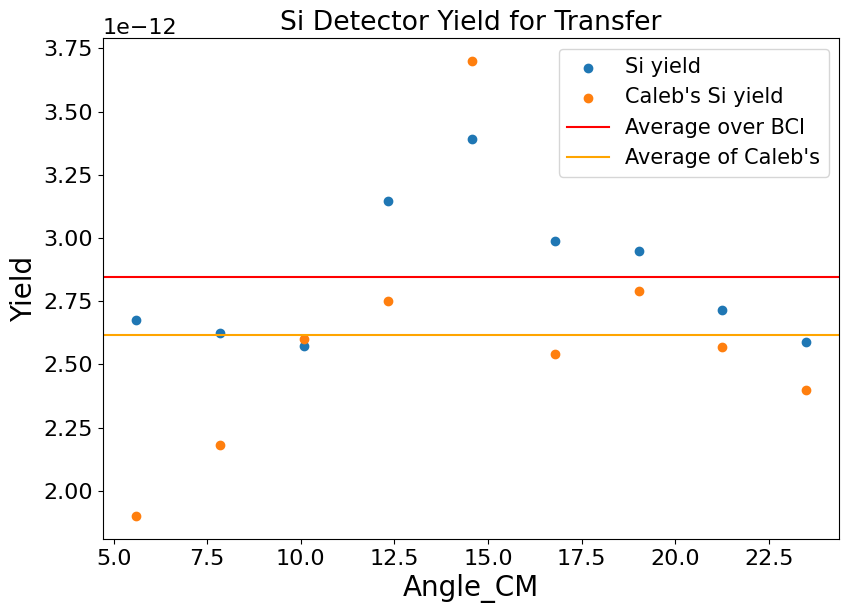

In [58]:
makefigure('Si Detector Yield for Transfer','Angle_CM','Yield')
plt.scatter(Angle_CM,Yield_t_si,label='Si yield')
# plt.scatter(Angle_CM,[1.9e-12,2.18e-12,2.6e-12,2.75e-12,3.70e-12,2.54e-12,2.79e-12,2.57e-12,2.4e-12],label='Caleb11390')
Yield_t_si_caleb=[1.9E-12,2.18E-12,2.6E-12,2.75E-12,3.7E-12,2.54E-12,2.79E-12,2.57E-12,2.4E-12]
plt.scatter(Angle_CM,Yield_t_si_caleb,label='Caleb\'s Si yield')
plt.axhline(y=avg_Yield_t_si, color='r', linestyle='-',label='Average over BCI')
avg_Yield_t_si_caleb=weighted_average(Yield_t_si_caleb,df_t_si['(BCI*LTR)_Summed'])
plt.axhline(y=avg_Yield_t_si_caleb, color='orange', linestyle='-',label='Average of Caleb\'s')
plt.legend(fontsize=15)
plt.show()
# print(avg_Yield_t_si/weighted_average(Yield_t_si_caleb,df_t_si['(BCI*LTR)_Summed'])-1)
# print("My Si yield is larger than Caleb's for:",(avg_Yield_t_si-avg_Yield_t_si_caleb)/avg_Yield_t_si_caleb*100,'%')

In [59]:
np.sqrt(np.sum(((Yield_t_si-avg_Yield_t_si)/avg_Yield_t_si)**2)/(len(Yield_t_si)-1))

0.10076448883729393

### Correct transfer yield from Si detector data

Next we would like to normalize the transfer yield with the monitor detector yield according to eqn.(6.15) on page 136 in Caleb's thesis:

$$\frac{d Y}{d \Omega}\left(\theta_{i}\right)=\left[\frac{d Y}{d \Omega}_{F P}\left(\theta_{i}\right) / \frac{d Y}{d \Omega}_{\text {Si}}\right]$$

The reasoning behind this is desctibed on page 131, sect 6.8 in Caleb's thesis.

Normalized Yield: 
5.604805536517591 	 0.020191006990516305
7.845710895797162 	 0.018778516814417407
10.085600691989525 	 0.016636621190558195
12.324186610801402 	 0.014775155451817073
14.561181723785024 	 0.01874908739033015
16.796300797259107 	 0.01261335296292431
19.0292606017338 	 0.012614454041289
21.25978022186898 	 0.00660197513517744
23.487581366966623 	 0.004641998742394138


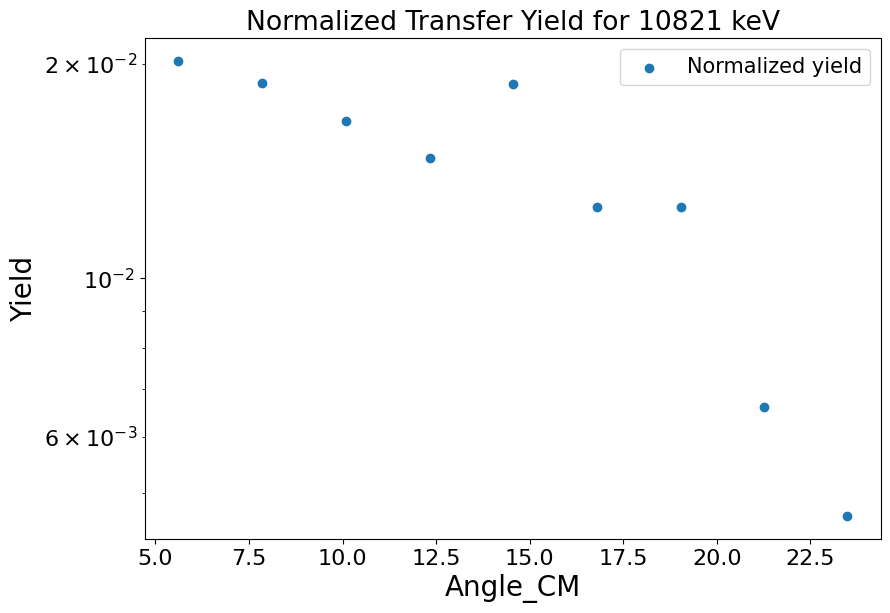

In [60]:
Yield_norm=Yield_trans/Yield_t_si
print('Normalized Yield: ')
layout(Angle_CM,Yield_norm)
makefigure('Normalized Transfer Yield for '+level+' keV','Angle_CM','Yield')
plt.scatter(Angle_CM,Yield_norm,label='Normalized yield')
plt.legend(fontsize=15)
plt.yscale('log')
# plt.ylim(1e-2,3e-1)

plt.show()

### Calculate uncertainties

Now I'm going to evaluate the uncertainties of the yield data. There are 3 sources: measuring the area of FP detector data peaks, si detector peaks, and a run-to-run fluctuation measured from si detector.
$$$$
$$\sigma_{Y}=\sqrt{\sigma_{Atrans}^{2}+\sigma_{Asi}^{2}+\sigma_{si-fluc}^{2}}$$
$$$$
To measure the Na peak area from si detector in each run, the same region of background and peak area are chosen. To facilitate the work, a total count of the peak is recorded without fitting, which has a ~3% difference compared with fitting a lognormal function. Furthermore, I took out all the scaling factors and calculate the uncertainty as a percentage of the yield.
$$$$
$$\frac{\sigma_{si-fluc}(\theta)}{\sigma_{Y}(\theta)}=\sqrt{\sum_{i}\{\frac{\epsilon_i}{\epsilon_{total}}[\frac{\sigma_{i}(\theta)-\sigma_{total}(\theta)}{\sigma_{total}(\theta)}]^2\}}$$
$$$$
Here I use $\epsilon=(BCI*LTR)$ as a weight because it reflects the amount data we collected, and the reliability. The summation is over each individual runs at an angle $\theta$.

In [61]:

df_t_u=pd.read_csv(path_specdata+'/'+'Si_transfer_RuntoRun.txt',sep='\t')
# print(df_t_u)
uncertainty_runtorun=[]
for angle in df_t['Angle_LAB']:
#     df_selected_angle=df_t_u.loc[df_t_u['Angle_LAB'] == angle]
#     Yield_unnorm=weighted_average(df_selected_angle['Area'],df_selected_angle['(BCI*LTR)_Summed'])
#     uncertainty_runtorun.append(np.sqrt(sum(((df_selected_angle['Area']-Yield_unnorm)/Yield_unnorm*df_selected_angle['(BCI*LTR)_Summed'])**2))/sum(df_selected_angle['(BCI*LTR)_Summed']))
#     print(uncertainty_runtorun[-1])
    df_selected_angle=df_t_u.loc[df_t_u['Angle_LAB'] == angle]
    Yield_runtorun=df_selected_angle['Area']/df_selected_angle['(BCI*LTR)_Summed']
    Yield_unnorm=df_t_si.loc[df_t['Angle_LAB'] == angle]['Area']/df_t_si.loc[df_t['Angle_LAB'] == angle]['(BCI*LTR)_Summed']
    Yield_unnorm=Yield_unnorm.values
    uncertainty_runtorun.append(np.sqrt(sum(((Yield_runtorun-Yield_unnorm)/Yield_unnorm)**2*df_selected_angle['(BCI*LTR)_Summed']/df_t_si.loc[df_t['Angle_LAB'] == angle]['(BCI*LTR)_Summed'].values)))
Yield_uncertainty=np.sqrt((df_t['+/-.1']/df_t['Area'])**2+(df_t_si['+/-.1']/df_t_si['Area'])**2+np.array(uncertainty_runtorun)**2)
Yield_uncertainty

0    0.200233
1    0.086857
2    0.226842
3    0.126678
4    0.285061
5    0.108167
6    0.100989
7    0.093245
8    0.258326
dtype: float64

### Cross section

At this point we can save the yield data and run MCMC. Alternatively, I'll try to extract the cross section and $C^2S$ with traditional calculations below.
I use eqn.(3.31) from Kiana's thesis p.107 to calculate the cross section from the yield:
$$\left(\frac{d \sigma}{d \Omega}\right)_{\theta}=\left(\frac{d Y}{d \Omega}\right)_{\theta} \frac{n A}{\left(3.75 \times 10^{3}\right) q \nu \Delta x}\times 10^{-3}$$
Multiplying $10^{-3}$ to convert the unit from $\mu b/sr$ to $mb/sr$. $A$ is the atomic or molecular mass of the target in grams, $A=23$ for $^{23}Na$. $n$ is the number of unit charges carried by the beam particles, $n=2$ for $^3He$, $q$ is the total charge deposited by the beam (in mC), which can be calculated from BCI. $\Delta x$ is the target thickness in $mg/cm^2$, $\Delta x=70.18\space \mu g/cm^2=7.18\times 10^{-2}\space mg/cm^2$ according to the logbook. $\nu$ is the number of atoms per molecule, which is 1 for $NaBr$.

In [62]:
CrossSection_lab=Yield_norm*2*23/(3.75*10**3)/(df_t['BCI_Summed']*10**(-10)*10**3)/(7.18*10**-2)*10**-3
layout(Angle_CM,CrossSection_lab)

5.604805536517591 	 2.7590174505649326e-06
7.845710895797162 	 1.3647272947717901e-06
10.085600691989525 	 1.4480351948808189e-06
12.324186610801402 	 1.1856255863547331e-06
14.561181723785024 	 1.592468744782923e-06
16.796300797259107 	 6.339657393095901e-07
19.0292606017338 	 7.142859261955178e-07
21.25978022186898 	 2.674614204382831e-07
23.487581366966623 	 2.811986604312422e-07


Use eqn.(2.36) from page 24 of Caleb's thesis:
$$\frac{d \sigma}{d \Omega}_{E x p}=C^{2} S_{A+p} C^{2} S_{d+p} \frac{d \sigma}{d \Omega}_{\mathrm{DWBA}}$$
Also cite $C^{2} S_{d+p}=1.5$ $$$$
We get:$$C^{2} S_{A+p}= \frac23 \left(\frac{d \sigma}{d \Omega}_{E x p}\right)/\left(\frac{d \sigma}{d \Omega}_{\mathrm{DWBA}}\right)$$
Next, we run fresco DWBA calculations to get the cross section $\frac{d \sigma}{d \Omega}_{\mathrm{DWBA}}$.

## Run fresco for DWBA calculations

In [63]:
os.chdir(path_fresco)
if method=='zero_range':
    method=''
else:
    method='_'+method
fresco_input = path_fresco+'/FrescoInputFiles/Na23He3d_'+level+'keV'+method+'.in'
#elastic_data_path = path_fresco_data+'/23Na-3He-3He copy.data'
#transfer_data_path = path_fresco_data+'23Na-3He-d-'+level+'.txt'
filerun(fresco_input)

fresco</home/kaixin/Documents/23NaHe3d_Analysis/FrescoInputFiles/Na23He3d_10821keV.in> /dev/null


In [64]:
method

''

## Read fresco result, plot with scaled experiment data,  and estimate $C^2S$ from the scaling

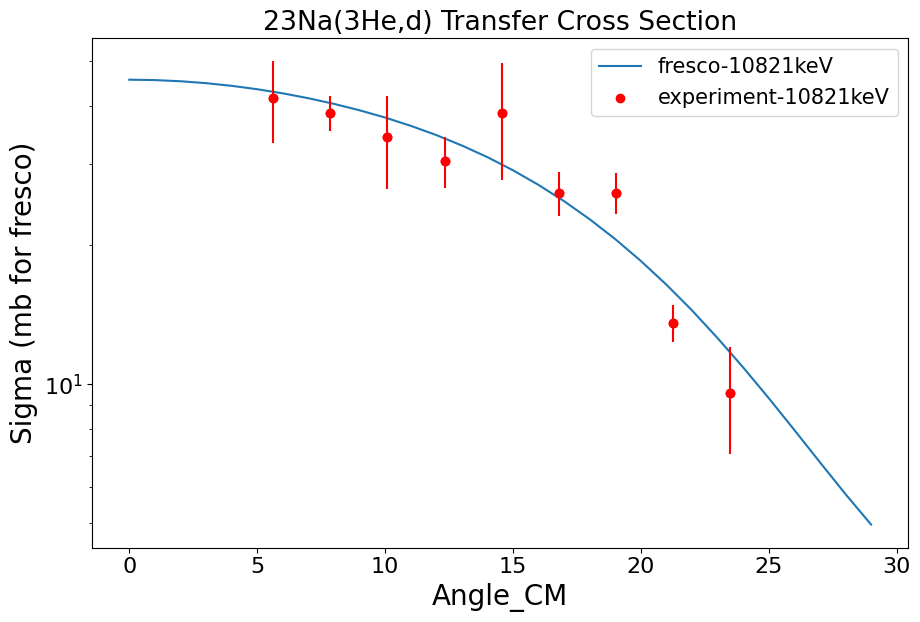

In [65]:
[theta_es, sigma_es] = read_cross('./fort.201')

[theta_trans, sigma_trans] = read_cross('./fort.202')
#??? #sigma_trans=[x/4/np.pi for x in sigma_trans]
spline_trans = interpolate.UnivariateSpline(theta_trans,sigma_trans,s=0)
makefigure('23Na(3He,d) Transfer Cross Section','Angle_CM','Sigma (mb for fresco)')
plt.plot(theta_trans[0:30], spline_trans(theta_trans)[0:30], label='fresco-'+level+'keV', lw=1.5)
# plt.errorbar(expES.theta, expES.sigma, expES.erry, label='Experiment-'+level+'keV',fmt='o', color='k')
scaling_factor_trans=np.average(Yield_norm)/np.average(spline_trans(Angle_CM))
exp=LineObject(Angle_CM,Yield_norm)
# trans=LineObject(theta_trans, sigma_trans)
# scaling_factor_trans=1/Minimizations.ScaleMinimize(exp,trans).x
plt.scatter(Angle_CM,Yield_norm/scaling_factor_trans,color='red',label='experiment-'+level+'keV')
plt.errorbar(Angle_CM, Yield_norm/scaling_factor_trans, yerr=Yield_norm/scaling_factor_trans*Yield_uncertainty, fmt="o",color='red')
plt.yscale('log')
plt.legend(fontsize=15)
plt.tight_layout()
# C2S=3/2*scaling_factor_trans*7.25 #Smaller than MCMC results by a factor
# print('C2S =',C2S)
# print('(2J+1)C2S =',(2*3+1)*C2S) 


## Save yield data for MCMC calculations

In [66]:
# ratio of transfer yield to si detector yield, we know it's proportional to the cross section.
d = {'Theta(CM)': Angle_CM, 'Sigma_Ratio': Yield_norm, 'uncertainty':Yield_norm*Yield_uncertainty}
df = pd.DataFrame(data=d)
df.to_csv(path_fresco_data+'/23Na-3He-d-'+level+'keV.data',sep='\t',index=False)


In [67]:
layout(Angle_CM,Yield_t_si)

5.604805536517591 	 2.674779081121486e-12
7.845710895797162 	 2.625790851530185e-12
10.085600691989525 	 2.5719603301643633e-12
12.324186610801402 	 3.1471886128177113e-12
14.561181723785024 	 3.391343352365892e-12
16.796300797259107 	 2.9897225991874596e-12
19.0292606017338 	 2.94856273818407e-12
21.25978022186898 	 2.7131203675538553e-12
23.487581366966623 	 2.5865214929595635e-12


In [68]:
angle=5
df_selected_angle=df_t_u.loc[df_t_u['Angle_LAB'] == angle]
Yield_runtorun=df_selected_angle['Area']/df_selected_angle['(BCI*LTR)_Summed']
Yield_unnorm=df_t_si.loc[df_t['Angle_LAB'] == angle]['Area']/df_t_si.loc[df_t['Angle_LAB'] == angle]['(BCI*LTR)_Summed']
Yield_unnorm=Yield_unnorm.values
np.sqrt(sum(((Yield_runtorun-Yield_unnorm)/Yield_unnorm)**2*df_selected_angle['(BCI*LTR)_Summed']/df_t_si.loc[df_t['Angle_LAB'] == angle]['(BCI*LTR)_Summed'].values))

# uncertainty_runtorun.append(np.sqrt(sum(((df_selected_angle['Area']-Yield_unnorm)/Yield_unnorm*df_selected_angle['(BCI*LTR)_Summed'])**2))/sum(df_selected_angle['(BCI*LTR)_Summed']))

0.181343624275484

In [69]:
df_t_u=pd.read_csv(path_specdata+'/'+'Si_transfer_RuntoRun.txt',sep='\t')
# print(df_t_u)
uncertainty_runtorun=[]
uncertainty_runtorun_runs=[]
# for angle in df_t['Angle_LAB']:
#     df_selected_angle=df_t_u.loc[df_t_u['Angle_LAB'] == angle]
#     Yield_unnorm=weighted_average(df_selected_angle['Area'],df_selected_angle['(BCI*LTR)_Summed'])
#     uncertainty_runtorun.append(np.sqrt(sum(((df_selected_angle['Area']-Yield_unnorm)/Yield_unnorm*df_selected_angle['(BCI*LTR)_Summed'])**2))/sum(df_selected_angle['(BCI*LTR)_Summed']))
#     print(uncertainty_runtorun[-1])
angle=13
df_selected_angle=df_t_u.loc[df_t_u['Angle_LAB'] == angle]
Yield_runtorun=df_selected_angle['Area']/df_selected_angle['(BCI*LTR)_Summed']
Yield_unnorm=df_t_si.loc[df_t['Angle_LAB'] == angle]['Area']/df_t_si.loc[df_t['Angle_LAB'] == angle]['(BCI*LTR)_Summed']
Yield_unnorm=Yield_unnorm.values
uncertainty_runtorun.append(np.sqrt(sum(((Yield_runtorun-Yield_unnorm)/Yield_unnorm)**2*df_selected_angle['(BCI*LTR)_Summed']/df_t_si.loc[df_t['Angle_LAB'] == angle]['(BCI*LTR)_Summed'].values)))
uncertainty_runtorun_runs.append(np.sqrt(((Yield_runtorun-Yield_unnorm)/Yield_unnorm)**2*df_selected_angle['(BCI*LTR)_Summed']/df_t_si.loc[df_t['Angle_LAB'] == angle]['(BCI*LTR)_Summed'].values))
uncertainty_runtorun_runs

[15    0.054262
 16    0.093246
 17    0.076628
 18    0.036987
 19    0.056828
 20    0.086526
 dtype: float64]